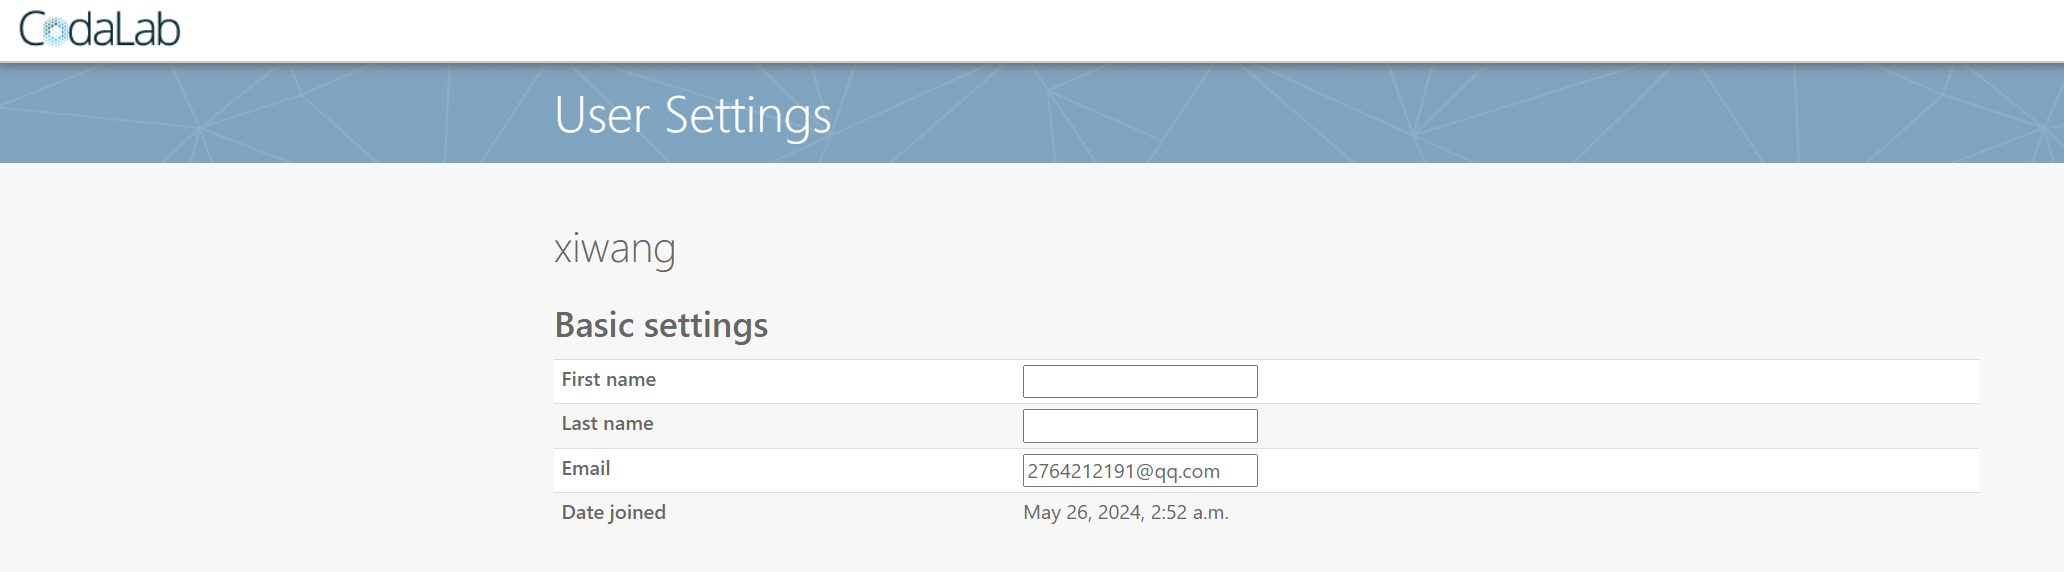

In [4]:



from IPython.display import Image

# 显示图像
Image(filename='1.png')



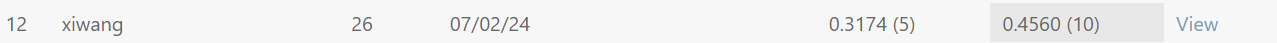

In [1]:
from IPython.display import Image

# 显示图像
Image(filename='2.png')

1、模型

darknet网络

In [ ]:
# 路径: ./model/darknet.py
import torch.nn as nn


def conv(in_ch, out_ch, k_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, k_size, stride, padding, bias=False),
        nn.LeakyReLU(0.1)
    )


def make_layer(param):
    layers = []
    if not isinstance(param[0], list):
        param = [param]
    for p in param:
        layers.append(conv(*p))
    return nn.Sequential(*layers)


class Block(nn.Module):
    def __init__(self, param, use_pool=True):
        super(Block, self).__init__()

        self.conv = make_layer(param)
        self.pool = nn.MaxPool2d(2)
        self.use_pool = use_pool

    def forward(self, x):
        x = self.conv(x)
        if self.use_pool:
            x = self.pool(x)
        return x


class DarkNet(nn.Module):
    def __init__(self):
        super(DarkNet, self).__init__()

        self.conv1 = Block([[3, 64, 7, 2, 3]])
        self.conv2 = Block([[64, 192, 3, 1, 1]])
        self.conv3 = Block([[192, 128, 1, 1, 0],
                            [128, 256, 3, 1, 1],
                            [256, 256, 1, 1, 0],
                            [256, 512, 3, 1, 1]])
        self.conv4 = Block([[512, 256, 1, 1, 0],
                            [256, 512, 3, 1, 1],
                            [512, 256, 1, 1, 0],
                            [256, 512, 3, 1, 1],
                            [512, 256, 1, 1, 0],
                            [256, 512, 3, 1, 1],
                            [512, 256, 1, 1, 0],
                            [256, 512, 3, 1, 1],
                            [512, 512, 1, 1, 0],
                            [512, 1024, 3, 1, 1]])
        self.conv5 = Block([[1024, 512, 1, 1, 0],
                            [512, 1024, 3, 1, 1],
                            [1024, 512, 1, 1, 0],
                            [512, 1024, 3, 1, 1],
                            [1024, 1024, 3, 1, 1],
                            [1024, 1024, 3, 2, 1]], False)
        self.conv6 = Block([[1024, 1024, 3, 1, 1],
                            [1024, 1024, 3, 1, 1]], False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        return x


if __name__ == "__main__":
    import torch

    x = torch.randn([1, 3, 448, 448])

    net = DarkNet()
    print(net)
    out = net(x)
    print(out.size())


resnet网络

In [ ]:
# 路径: ./model/resnet.py
import torch
from torchvision.models.resnet import ResNet, Bottleneck


"""
通过继承Pytorch的ResNet代码，重写其中的_forward_impl来去除最后的avgpool与fc层
此外我将Resnet50原有的layer4省略并额外增加了两个maxpool层，使得Resnet输出的特征图与Darknet一致
均为[1024, 7, 7]
"""
class ResNet_(ResNet):
    def __init__(self, block, layers):
        super(ResNet_, self).__init__(block=block, layers=layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.maxpool(x)
        x = self.layer3(x)
        x = self.maxpool(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(block, layers, pretrained):
    model = ResNet_(block, layers)
    if pretrained is not None:
        state_dict = torch.load(pretrained)
        model.load_state_dict(state_dict)
    return model


def resnet_1024ch(pretrained=None) -> ResNet:
    resnet = _resnet(Bottleneck, [3, 4, 6, 3], pretrained)
    return resnet


if __name__ == '__main__':
    x = torch.randn([1, 3, 448, 448])
    net = resnet_1024ch('resnet50-19c8e357.pth')
    print(net)

    y = net(x)
    print(y.size())


yolo模型

In [ ]:
import numpy as np
from torch import optim

from model.darknet import DarkNet
from model.resnet import resnet_1024ch

import torch
import torch.nn as nn
import torchvision

# YOLO模型定义
class yolo(nn.Module):
    def __init__(self, s, cell_out_ch, backbone_name, pretrain=None):
        """
        初始化YOLO模型
        :param s: 网格大小
        :param cell_out_ch: 每个网格输出通道数
        :param backbone_name: 主干网络名称
        :param pretrain: 预训练权重
        :return: [s, s, cell_out_ch]
        """
        super(yolo, self).__init__()
        self.s = s
        self.backbone = None
        self.conv = None
        if backbone_name == 'darknet':
            self.backbone = DarkNet()
        elif backbone_name == 'resnet':
            self.backbone = resnet_1024ch(pretrained=pretrain)
        self.backbone_name = backbone_name

        assert self.backbone is not None, 'Wrong backbone name'

        self.fc = nn.Sequential(
            nn.Linear(1024 * s * s, 4096),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(4096, s * s * cell_out_ch)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = x.view(batch_size, self.s ** 2, -1)
        return x

# YOLO损失计算
class yolo_loss:
    def __init__(self, device, s, b, image_size, num_classes):
        """
        初始化YOLO损失函数
        :param device: 设备类型
        :param s: 网格大小
        :param b: 每个网格的预测边界框数量
        :param image_size: 输入图像大小
        :param num_classes: 类别数量
        """
        self.device = device
        self.s = s
        self.b = b
        self.image_size = image_size
        self.num_classes = num_classes
        self.batch_size = 0

    def __call__(self, input, target):
        """
        计算损失
        :param input: YOLO网络输出 [s, s, b*5 + n_class]
        :param target: 数据集标签 [n_bbox, 5] bbox: x_min, ymin, xmax, ymax, class
        :return: 损失张量
        """
        self.batch_size = input.size(0)

        # 标签预处理
        target = [self.label_direct2grid(target[i]) for i in range(self.batch_size)]

        # IoU匹配预测框和标签
        match = []
        conf = []
        for i in range(self.batch_size):
            m, c = self.match_pred_target(input[i], target[i])
            match.append(m)
            conf.append(c)

        loss = torch.zeros([self.batch_size], dtype=torch.float, device=self.device)
        xy_loss = torch.zeros_like(loss)
        wh_loss = torch.zeros_like(loss)
        conf_loss = torch.zeros_like(loss)
        class_loss = torch.zeros_like(loss)
        for i in range(self.batch_size):
            loss[i], xy_loss[i], wh_loss[i], conf_loss[i], class_loss[i] = \
                self.compute_loss(input[i], target[i], match[i], conf[i])
        return torch.mean(loss), torch.mean(xy_loss), torch.mean(wh_loss), torch.mean(conf_loss), torch.mean(class_loss)

    def label_direct2grid(self, label):
        """
        将标签转换为网格形式
        :param label: 数据集标签 [xmin, ymin, xmax, ymax, class]
        :return: 转换后的标签
        """
        output = [None for _ in range(self.s ** 2)]
        size = self.image_size // self.s  # h, w

        n_bbox = label.size(0)
        label_c = torch.zeros_like(label)

        label_c[:, 0] = (label[:, 0] + label[:, 2]) / 2
        label_c[:, 1] = (label[:, 1] + label[:, 3]) / 2
        label_c[:, 2] = abs(label[:, 0] - label[:, 2])
        label_c[:, 3] = abs(label[:, 1] - label[:, 3])
        label_c[:, 4] = label[:, 4]

        idx_x = [int(label_c[i][0]) // size for i in range(n_bbox)]
        idx_y = [int(label_c[i][1]) // size for i in range(n_bbox)]

        label_c[:, 0] = torch.div(torch.fmod(label_c[:, 0], size), size)
        label_c[:, 1] = torch.div(torch.fmod(label_c[:, 1], size), size)
        label_c[:, 2] = torch.div(label_c[:, 2], self.image_size)
        label_c[:, 3] = torch.div(label_c[:, 3], self.image_size)

        for i in range(n_bbox):
            idx = idx_y[i] * self.s + idx_x[i]
            if output[idx] is None:
                output[idx] = torch.unsqueeze(label_c[i], dim=0)
            else:
                output[idx] = torch.cat([output[idx], torch.unsqueeze(label_c[i], dim=0)], dim=0)
        return output

    def match_pred_target(self, input, target):
        """
        匹配预测框和标签
        :param input: YOLO网络输出
        :param target: 数据集标签
        :return: 匹配结果
        """
        match = []
        conf = []
        with torch.no_grad():
            input_bbox = input[:, :self.b * 5].reshape(-1, self.b, 5)
            ious = [match_get_iou(input_bbox[i], target[i], self.s, i)
                    for i in range(self.s ** 2)]
            for iou in ious:
                if iou is None:
                    match.append(None)
                    conf.append(None)
                else:
                    keep = np.ones([len(iou[0])], dtype=bool)
                    m = []
                    c = []
                    for i in range(self.b):
                        if np.any(keep) == False:
                            break
                        idx = np.argmax(iou[i][keep])
                        np_max = np.max(iou[i][keep])
                        m.append(np.argwhere(iou[i] == np_max).tolist()[0][0])
                        c.append(np.max(iou[i][keep]))
                        keep[idx] = 0
                    match.append(m)
                    conf.append(c)
        return match, conf

    def compute_loss(self, input, target, match, conf):
        """
        计算损失
        :param input: YOLO网络输出
        :param target: 数据集标签
        :param match: 匹配结果
        :param conf: 置信度
        :return: 各种损失
        """
        ce_loss = nn.CrossEntropyLoss()

        input_bbox = input[:, :self.b * 5].reshape(-1, self.b, 5)
        input_class = input[:, self.b * 5:].reshape(-1, self.num_classes)

        input_bbox = torch.sigmoid(input_bbox)
        loss = torch.zeros([self.s ** 2], dtype=torch.float, device=self.device)
        xy_loss = torch.zeros_like(loss)
        wh_loss = torch.zeros_like(loss)
        conf_loss = torch.zeros_like(loss)
        class_loss = torch.zeros_like(loss)
        # 不同grid cell分别计算再求和
        for i in range(self.s ** 2):
            # 0 xy_loss, 1 wh_loss, 2 conf_loss, 3 class_loss
            l = torch.zeros([4], dtype=torch.float, device=self.device)
            # Neg
            if target[i] is None:
                # λ_noobj = 0.5
                obj_conf_target = torch.zeros([self.b], dtype=torch.float, device=self.device)
                l[2] = torch.sum(torch.mul(0.5, torch.pow(input_bbox[i, :, 4] - obj_conf_target, 2)))
            else:
                # λ_coord = 5
                l[0] = torch.mul(5, torch.sum(torch.pow(input_bbox[i, :, 0] - target[i][match[i], 0], 2) +
                                              torch.pow(input_bbox[i, :, 1] - target[i][match[i], 1], 2)))

                l[1] = torch.mul(5, torch.sum(torch.pow(torch.sqrt(input_bbox[i, :, 2]) -
                                                        torch.sqrt(target[i][match[i], 2]), 2) +
                                              torch.pow(torch.sqrt(input_bbox[i, :, 3]) -
                                                        torch.sqrt(target[i][match[i], 3]), 2)))
                obj_conf_target = torch.tensor(conf[i], dtype=torch.float, device=self.device)
                l[2] = torch.sum(torch.pow(input_bbox[i, :, 4] - obj_conf_target, 2))

                l[3] = ce_loss(input_class[i].unsqueeze(dim=0).repeat(target[i].size(0), 1),
                               target[i][:, 4].long())
            loss[i] = torch.sum(l)
            xy_loss[i] = l[0]
            wh_loss[i] = l[1]
            conf_loss[i] = l[2]
            class_loss[i] = l[3]
        return torch.sum(loss), torch.sum(xy_loss), torch.sum(wh_loss), torch.sum(conf_loss), torch.sum(class_loss)

# 获取标签与预测的IoU
def match_get_iou(input_bbox, target_bbox, s, i):
    """
    计算预测框和标签的IoU
    :param input_bbox: 预测框
    :param target_bbox: 标签
    :param s: 网格大小
    :param i: 网格索引
    :return: IoU
    """
    if target_bbox is None:
        return None

    with torch.no_grad():
        output = [torch.zeros([target_bbox.size(0)], dtype=torch.float, device='cpu') for _ in range(input_bbox.size(0))]

        grid_x = int(i % s)
        grid_y = int(i / s)
        size = 448 // s  # h, w

        input_bbox[:, 0] = torch.mul(input_bbox[:, 0] + grid_x, size)
        input_bbox[:, 1] = torch.mul(input_bbox[:, 1] + grid_y, size)
        input_bbox[:, 2] = torch.mul(input_bbox[:, 2], 448)
        input_bbox[:, 3] = torch.mul(input_bbox[:, 3], 448)

        target_bbox[:, 0] = torch.mul(target_bbox[:, 0] + grid_x, size)
        target_bbox[:, 1] = torch.mul(target_bbox[:, 1] + grid_y, size)
        target_bbox[:, 2] = torch.mul(target_bbox[:, 2], 448)
        target_bbox[:, 3] = torch.mul(target_bbox[:, 3], 448)

        for i in range(input_bbox.size(0)):
            inpt = input_bbox[i]
            x_min_1 = inpt[0] - inpt[2] / 2
            x_max_1 = inpt[0] + inpt[2] / 2
            y_min_1 = inpt[1] - inpt[3] / 2
            y_max_1 = inpt[1] + inpt[3] / 2
            for j in range(target_bbox.size(0)):
                t = target_bbox[j]
                x_min_2 = t[0] - t[2] / 2
                x_max_2 = t[0] + t[2] / 2
                y_min_2 = t[1] - t[3] / 2
                y_max_2 = t[1] + t[3] / 2
                if x_min_1 > x_max_2 or x_min_2 > x_max_1 or y_min_1 > y_max_2 or y_min_2 > y_max_1:
                    output[i][j] = 0
                else:
                    S_1 = abs(x_max_1 - x_min_1) * abs(y_max_1 - y_min_1)
                    S_2 = abs(x_max_2 - x_min_2) * abs(y_max_2 - y_min_2)

                    left = torch.max(x_min_1, x_min_2)
                    right = torch.min(x_max_1, x_max_2)
                    top = torch.max(y_min_1, y_min_2)
                    bottom = torch.min(y_max_1, y_max_2)
                    inter = abs(left - right) * abs(top - bottom)
                    output[i][j] = inter / (S_1 + S_2 - inter)
        return output

# 优化器
def create_optimizer(model, optimizer_type, learning_rate):
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer type. Choose between 'adam' or 'sgd'.")
    return optimizer

# 主程序
def main():
    # 超参数
    S = 7  # 网格大小
    B = 2  # 每个网格的预测边界框数量
    num_classes = 20  # 类别数量
    image_size = 448  # 输入图像大小
    batch_size = 16
    learning_rate = 0.001
    optimizer_type = 'adam'

    # 设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 模型、损失函数和优化器
    model = yolo(S, B * 5 + num_classes, 'resnet', pretrain=True).to(device)
    criterion = yolo_loss(device, S, B, image_size, num_classes)
    optimizer = create_optimizer(model, optimizer_type, learning_rate)

    # 数据集加载
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_size, image_size)),
        torchvision.transforms.ToTensor(),
    ])
    dataset = torchvision.datasets.VOCDetection(root='./data', year='2007', image_set='train', download=True, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # 训练
    num_epochs = 50
    model.train()
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader):
            inputs, targets = data
            inputs = inputs.to(device)
            targets = [torch.tensor(t['annotation']['object']) for t in targets]
            targets = [t.to(device) for t in targets]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss, xy_loss, wh_loss, conf_loss, class_loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}, XY Loss: {xy_loss.item()}, WH Loss: {wh_loss.item()}, Conf Loss: {conf_loss.item()}, Class Loss: {class_loss.item()}')

if __name__ == "__main__":
    main()


2、数据处理

In [ ]:
import torch
import cv2
import numpy as np

from pycocotools.coco import COCO

In [ ]:

# 预处理图像函数
def preprocess_image(image_path, input_size=448):
    # 读取图像文件
    image = cv2.imread(image_path)
    # 调整图像大小到指定的输入尺寸 (input_size, input_size)
    image = cv2.resize(image, (input_size, input_size))
    # 将图像的像素值归一化到 [0, 1] 范围内
    image = image / 255.0
    # 将 NumPy 数组转换为 PyTorch 张量，并调整维度顺序
    image = torch.FloatTensor(image).permute(2, 0, 1)
    return image

# 创建YOLO目标函数
def create_yolo_target(annotations, img_width, img_height, grid_size=7, num_bboxes=1, num_classes=21):
    ans = []
    for ann in annotations:
        bbox = ann['bbox']  # 获取边界框
        category = ann['category_id']  # 获取类别ID
        # 归一化并转换边界框坐标
        ans.append(torch.tensor([bbox[0] / img_width * 448, bbox[1] / img_height * 448, bbox[2] / img_width * 448, bbox[3] / img_height * 448, category]))
    target = torch.stack(ans)  # 堆叠所有目标为一个张量
    return target
# 数据生成器函数
def data_generator(batch_size=32, input_size=448):
    image_ids = coco.getImgIds()  # 获取所有图像ID
    image_info = coco.loadImgs(image_ids)  # 加载所有图像信息
    for i in range(0, len(image_info), batch_size):
        batch_image = []
        batch_target = []
        batch_info = []
        for info in image_info[i:i + batch_size]:
            image_path = 'dl_detection/train/' + info['file_name']  # 获取图像路径
            image = preprocess_image(image_path, input_size)  # 预处理图像
            batch_image.append(image)
            annotation_ids = coco.getAnnIds(imgIds=info['id'])  # 获取图像对应的注释ID
            annotations = coco.loadAnns(annotation_ids)  # 加载注释
            target = create_yolo_target(annotations, info['width'], info['height'])  # 创建YOLO目标
            batch_target.append(target)
            batch_info.append([info['id'], info['width'], info['height']])  # 保存图像信息

        X_batch = torch.stack(batch_image)  # 将批处理图像堆叠为一个张量
        info_batch = torch.tensor(batch_info)  # 转换批处理信息为张量
        yield X_batch, batch_target, info_batch  # 生成批处理数据


In [ ]:
# 加载COCO数据集
coco = COCO('dl_detection/annotations/train.json')

batch_idx = 0
# 使用生成器逐批处理数据
for X_batch, Y_batch, info_batch in data_generator():
    data = {
        'X': X_batch,
        'Y': Y_batch,
        'info': info_batch
    }
    # 保存批处理数据到文件
    np.save(f"train_data/train_data_batch_{batch_idx}.npy", data)
    batch_idx += 1
    print(Y_batch[0].shape)
print("ok")

3、训练过程

学习率控制

In [ ]:
# 路径: ./scheduler.py
from torch.optim.lr_scheduler import _LRScheduler

class Scheduler(_LRScheduler):
    def __init__(self, optimizer, step_warm_ep, lr_start, step_1_lr, step_1_ep,
                 step_2_lr, step_2_ep, step_3_lr, step_3_ep, last_epoch=-1):
        """
        初始化自定义学习率调度器
        :param optimizer: 优化器
        :param step_warm_ep: 预热阶段的epoch数
        :param lr_start: 起始学习率
        :param step_1_lr: 阶段1学习率
        :param step_1_ep: 阶段1的epoch数
        :param step_2_lr: 阶段2学习率
        :param step_2_ep: 阶段2的epoch数
        :param step_3_lr: 阶段3学习率
        :param step_3_ep: 阶段3的epoch数
        :param last_epoch: 上一个epoch的编号
        """
        self.optimizer = optimizer
        self.lr_start = lr_start
        self.step_warm_ep = step_warm_ep
        self.step_1_lr = step_1_lr
        self.step_1_ep = step_1_ep
        self.step_2_lr = step_2_lr
        self.step_2_ep = step_2_ep
        self.step_3_lr = step_3_lr
        self.step_3_ep = step_3_ep
        self.last_epoch = last_epoch

        super(Scheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        """
        获取当前学习率
        :return: 当前学习率列表
        """
        if self.last_epoch == 0:
            return [self.lr_start for _ in self.optimizer.param_groups]
        lr = self._compute_lr_from_epoch()
        return [lr for _ in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        """
        获取封闭形式的学习率（基于初始学习率）
        :return: 初始学习率列表
        """
        return self.base_lrs

    def _compute_lr_from_epoch(self):
        """
        根据当前epoch计算学习率
        :return: 当前学习率
        """
        if self.last_epoch < self.step_warm_ep:
            lr = ((self.step_1_lr - self.lr_start) / self.step_warm_ep) * self.last_epoch + self.lr_start
        elif self.last_epoch < self.step_warm_ep + self.step_1_ep:
            lr = self.step_1_lr
        elif self.last_epoch < self.step_warm_ep + self.step_1_ep + self.step_2_ep:
            lr = self.step_2_lr
        elif self.last_epoch < self.step_warm_ep + self.step_1_ep + self.step_2_ep + self.step_3_ep:
            lr = self.step_3_lr
        else:
            lr = self.step_3_lr
        return lr

if __name__ == '__main__':
    import torch.nn as nn
    import torch.optim as optim

    import numpy as np
    import matplotlib.pyplot as plt

    import warnings
    warnings.filterwarnings('ignore')

    # 模型参数
    batch_size = 16
    epoch = 135
    scheduler_params = {
        'lr_start': 1e-3,
        'step_warm_ep': 10,
        'step_1_lr': 1e-2,
        'step_1_ep': 75,
        'step_2_lr': 1e-3,
        'step_2_ep': 30,
        'step_3_lr': 1e-4,
        'step_3_ep': 20
    }

    # 简单的线性模型
    model = nn.Sequential(
        nn.Linear(1, 10),
        nn.Linear(10, 1)
    )
    optimizer = optim.SGD(model.parameters(), lr=scheduler_params['lr_start'])
    scheduler = Scheduler(optimizer, **scheduler_params)

    lrs = []
    for _ in range(epoch):
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
    print(lrs)

    lrs = np.array(lrs)

    # 使用plt可视化学习率
    plt.figure()
    plt.plot(lrs)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()


主训练过程

In [ ]:
import numpy as np
from model.yolo import yolo, yolo_loss
from scheduler import Scheduler
from torch import optim
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
import os
import torch


In [ ]:
# 数据迭代器，用于从文件中读取训练数据
def data_iter(num_batches=1043, file_prefix="train_data/train_data_batch_", file_suffix=".npy"):
    for batch_idx in range(num_batches):
        file_path = f"{file_prefix}{batch_idx}{file_suffix}"
        data = np.load(file_path, allow_pickle=True).item()
        X_batch = data['X']
        Y_batch = data['Y']
        info_batch = data['info']
        yield X_batch, Y_batch, info_batch

# 自定义collate函数，用于数据加载时的批处理
def collate_fn(batch):
    return tuple(zip(*batch))
# 用于计算和存储指标的平均值
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# 配置类，包含各种超参数和训练设置
class CFG:
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model_root = r'./log/ex7'
    backbone = 'resnet'
    pretrain = 'model/resnet50-19c8e357.pth'
    with_amp = True
    S = 7
    B = 2
    num_classes = 21
    image_size = 448
    start_epoch = 0
    epoch = 135
    batch_size = 16
    num_workers = 2
    freeze_backbone_till = 30

    scheduler_params = {
        'lr_start': 1e-3 / 4,
        'step_warm_ep': 10,
        'step_1_lr': 1e-2 / 4,
        'step_1_ep': 75,
        'step_2_lr': 1e-3 / 4,
        'step_2_ep': 40,
        'step_3_lr': 1e-4 / 4,
        'step_3_ep': 10
    }

    momentum = 0.9
    weight_decay = 0.0005

In [ ]:
# 训练函数
def train():

    # 初始化YOLO模型
    yolo_net = yolo(s=CFG.S, cell_out_ch=CFG.B * 5 + CFG.num_classes, backbone_name=CFG.backbone, pretrain=CFG.pretrain)
    model_path = os.path.join(CFG.model_root, 'yolo.pth')
    yolo_net.load_state_dict(torch.load(model_path))
    yolo_net.to(CFG.device)

    # 冻结backbone部分的参数
    if CFG.freeze_backbone_till != -1:
        print('Freeze Backbone')
        for param in yolo_net.backbone.parameters():
            param.requires_grad_(False)

    param = [p for p in yolo_net.parameters() if p.requires_grad]
    optimizer = optim.SGD(param, lr=CFG.scheduler_params['lr_start'], momentum=CFG.momentum, weight_decay=CFG.weight_decay)
    criterion = yolo_loss(CFG.device, CFG.S, CFG.B, CFG.image_size, CFG.num_classes)
    scheduler = Scheduler(optimizer, **CFG.scheduler_params)
    scaler = GradScaler()

    # 恢复学习率调度器的步数
    for _ in range(CFG.start_epoch):
        scheduler.step()

    best_train_loss = 1e+9
    train_losses = []
    lrs = []

    for epoch in range(CFG.start_epoch, CFG.epoch):
        if CFG.freeze_backbone_till != -1 and epoch >= CFG.freeze_backbone_till:
            print('Unfreeze Backbone')
            for param in yolo_net.backbone.parameters():
                param.requires_grad_(True)
            CFG.freeze_backbone_till = -1

        yolo_net.train()
        loss_score = AverageMeter()

        for batch_index, (X, Y, info) in enumerate(data_iter(), start=1):
            if batch_index % 10 == 0:
                print(batch_index)
            optimizer.zero_grad()
            X = X.to(CFG.device)
            Y = [y.to(CFG.device) for y in Y]
            batch_size = len(Y)

            # 混合精度训练
            if CFG.with_amp:
                with autocast():
                    outputs = yolo_net(X)
                    loss, xy_loss, wh_loss, conf_loss, class_loss = criterion(outputs, Y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = yolo_net(X)
                loss, xy_loss, wh_loss, conf_loss, class_loss = criterion(outputs, Y)
                loss.backward()
                optimizer.step()

            loss_score.update(loss.detach().item(), batch_size)

        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
        train_losses.append(loss_score.avg)
        print('Train Loss: {:.4f}'.format(loss_score.avg))

        # 保存模型
        if best_train_loss > loss_score.avg:
            print('Save yolo_net to {}'.format(os.path.join(CFG.model_root, 'yolo.pth')))
            torch.save(yolo_net.state_dict(), os.path.join(CFG.model_root, 'yolo.pth'))
            best_train_loss = loss_score.avg

        loss_score.reset()

        # 保存训练损失和学习率到CSV文件
        df = pd.DataFrame({'Train Loss': train_losses, 'LR': lrs})
        df.to_csv(os.path.join(CFG.model_root, 'result.csv'), index=True)


In [ ]:
if __name__ == '__main__':
    train()

4、测试

In [ ]:
import numpy as np
from model.yolo import yolo, output_process
import pandas as pd
import os
import torch

In [ ]:
# 数据迭代器函数，从文件中逐批加载测试数据
def data_iter(num_batches=512, file_prefix="test_data/train_data_batch_", file_suffix=".npy"):
    for batch_idx in range(num_batches):
        file_path = f"{file_prefix}{batch_idx}{file_suffix}"
        data = np.load(file_path, allow_pickle=True).item()
        X_batch = data['X']
        info_batch = data['info']
        yield X_batch, info_batch

# 数据拼接函数，将批处理的数据拼接成一个批次
def collate_fn(batch):
    return tuple(zip(*batch))

# 配置类，包含训练和测试的超参数
class CFG:
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model_root = r'./log/ex7'
    backbone = 'resnet'
    pretrain = 'model/resnet50-19c8e357.pth'
    S = 7
    B = 2
    num_classes = 21
    image_size = 448
    conf_th = 0
    iou_th = 1

In [ ]:
# 测试函数
def test():
    # 加载YOLO模型
    yolo_net = yolo(s=CFG.S, cell_out_ch=CFG.B * 5 + CFG.num_classes, backbone_name=CFG.backbone, pretrain=CFG.pretrain)
    model_path = os.path.join(CFG.model_root, 'yolo.pth')
    yolo_net.load_state_dict(torch.load(model_path))
    yolo_net.to(CFG.device)
    yolo_net.eval()
    
    ids = []  # 存储图像ID
    predictions = []  # 存储预测结果
    max_conf = 0  # 最大置信度
    length_distribute = [0] * 10  # 置信度分布
    
    # 遍历批处理数据
    for batch_index, (X, info) in enumerate(data_iter(), start=1):
        with torch.no_grad():
            if batch_index % 10 == 0:
                print(batch_index)
            X = X.to(CFG.device)
            outputs = yolo_net(X)  # 获取模型输出

            # 处理每个输出
            for m, output in enumerate(outputs):
                output = output.unsqueeze(0)
                formatted_data = ""
                output = output_process(output.cpu(), CFG.image_size, CFG.S, CFG.B, CFG.conf_th, CFG.iou_th)
                nub = output.squeeze(dim=0).numpy().tolist()

                # 如果有预测结果
                if len(nub) > 0:
                    for out in nub:
                        xl = out[0] / 448 * info[m][1]
                        yl = out[1] / 448 * info[m][2]
                        xr = out[2] / 448 * info[m][1]
                        yr = out[3] / 448 * info[m][2]
                        conf = out[4] * out[5]
                        max_conf = max(max_conf, conf)
                        l = int(conf * 10)
                        length_distribute[l] += 1
                        class_id = out[6]
                        formatted = f"{{{xl.item()} {yl.item()} {xr.item()} {yr.item()} {conf} {class_id}}}"
                        formatted_data = formatted_data + formatted

                ids.append(info[m][0].item())
                predictions.append(formatted_data)

    # 保存结果到CSV文件
    df = pd.DataFrame({'image_id': ids, 'predictions': predictions})
    df.to_csv(os.path.join(CFG.model_root, 'test.csv'), index=False)
    print(max_conf)
    print(length_distribute)


In [ ]:
if __name__ == '__main__':
    test()

思路心得


项目背景
YOLO（You Only Look Once）是一种实时目标检测算法，以其速度和准确性著称。YOLOv1 是 YOLO 系列的第一个版本，它将目标检测问题转化为一个回归问题，通过单次前向传播来预测图像中的边界框和类别。


项目流程
数据准备
1.数据加载：使用 pycocotools 加载 COCO 数据集，并将数据集分批处理保存为 .npy 文件。
2.预处理：将图像缩放到统一尺寸（448x448），归一化像素值，并转换为 PyTorch 张量。
3.目标生成：根据 COCO 数据集的标注，生成 YOLO 格式的目标标签，包含边界框坐标和类别。


模型构建
1.YOLOv1 架构：使用预训练的 ResNet50 作为主干网络，并构建 YOLO 的头部层，用于预测每个网格单元的边界框和类别。
2.模型加载：加载预训练模型参数，并根据配置选择是否冻结主干网络。
损失函数
YOLO 损失函数：包括定位损失、置信度损失和分类损失，综合考虑预测的边界框位置、大小与实际标注的误差，以及分类准确性。


模型训练
1.优化器与调度器：使用 SGD 作为优化器，并根据训练阶段动态调整学习率。
2.混合精度训练：利用 PyTorch 的 GradScaler 和 autocast 提升训练速度和减少显存使用。
3.模型保存：在训练过程中，根据验证损失保存最佳模型参数。


模型测试
1.预测处理：使用训练好的模型对测试集进行预测，并根据置信度和 IoU 阈值筛选预测结果。
2.结果保存：将预测结果保存为 CSV 文件，记录每个测试图像的预测边界框和类别。


心得
YOLOv1 将目标检测问题转化为回归问题，通过单次前向传播实现目标检测，大大提升了速度。这种思路对于实时应用非常重要。
在数据处理过程中，注意图像缩放和归一化的细节，确保输入的一致性。同时，目标生成部分要仔细处理，确保边界框和类别的准确性。
YOLOv1 的损失函数综合考虑了定位、置信度和分类三方面的误差，是整个模型训练的关键。需要根据具体数据集和任务需求，调整损失函数的权重。
在大规模训练任务中，混合精度训练可以有效提升计算效率，减少显存占用，是非常实用的技术。
在训练过程中，定期保存模型参数，可以方便在测试阶段加载最佳模型。
通过本次 YOLOv1 的目标检测实践，深刻理解了目标检测的核心思路和实现细节，同时也积累了丰富的工程经验。







